# Binary Classification Model using CNN built from scratch.
## Making predictions.

I will try to build a Convolutional Neural Network using the `flow_from_directory` method for two classes:
    - Normal
    - Pneumonia

The CNN, built from scratch is trained using the balanced binary dataset built in previous notebooks.

## Imports

### Libraries

In [1]:
# General imports
import numpy as np
import random
import pandas as pd

# System and file management
import os
import zipfile
from imutils import paths

# Visualization Tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage.io import imread

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# jupyter:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# DICOM
import pydicom
from pydicom.filereader import dcmread

# Tensorflow
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# SKLEARN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Functions 

### Paths 

In [4]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_balanced') # Folder where the train and test subsets will be located
MODELS_PATH = os.path.join(PATH,'model')

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_NNNP_PATH = os.path.join(TRAIN_PATH, 'nnnp')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_NNNP_PATH = os.path.join(VAL_PATH, 'nnnp')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_NNNP_PATH = os.path.join(TEST_PATH, 'nnnp')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### CSV

In [5]:
balanced = pd.read_csv(os.path.join(CSV_PATH, 'balanced_cxr_information.csv'))

## Model Building 

### Preprocessing images 

In [6]:
img_width, img_height = 128, 128
BS = 64
NB = 2
EPOCHS = 15

In [7]:
TRAIN_LEN = len(list(paths.list_images(TRAIN_PATH)))
VAL_LEN = len(list(paths.list_images(VAL_PATH)))
TEST_LEN = len(list(paths.list_images(TEST_PATH)))

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # This is the source directory for training images
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=True,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        VAL_PATH,  # This is the source directory for training images
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=False,
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=False,
        class_mode='categorical')

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


### Network creation 

In [10]:
# Our input feature map is 512x512x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(img_width, img_height, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = Dropout(0.1)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# max-pooling is followed by a dropout to try to avoid overfitting
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 1024 hidden units
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting

# Create a fully connected layer with ReLU activation and 256 hidden units
x = Dense(256, activation = "relu")(x) # Create a fully connected layer with ReLU activation and 256 hidden units
x = Dropout(0.2)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting.

# Create output layer with a single node and sigmoid activation
output = layers.Dense(NB, activation='softmax')(x) # Create output layer with two nodes (binary output) and Softmax activation function


# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

#### Summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0     

## Intermediate steps visualization 

Steps extracted from [Google ML Practicum on Image Classification](https://developers.google.com/machine-learning/practica/image-classification)

In [13]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [14]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

In [33]:
img_path = os.path.join(TRAIN_NORMAL_PATH, os.listdir(TRAIN_NORMAL_PATH)[random.randint(1,len(TRAIN_NORMAL_PATH))])

In [34]:
img = load_img(img_path, target_size=(img_width, img_height))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (128, 128, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 128, 128, 3)
x /= 255 # Rescale by 1/255

In [35]:
# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

In [36]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

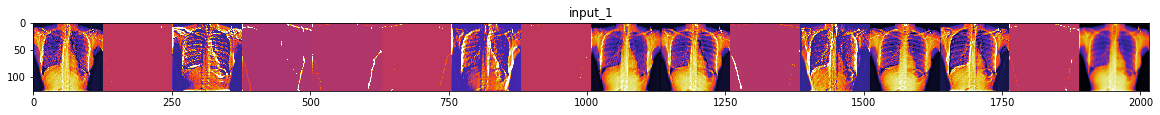

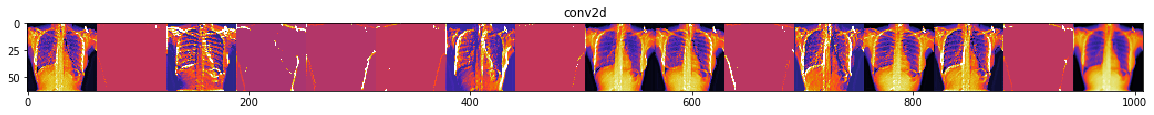

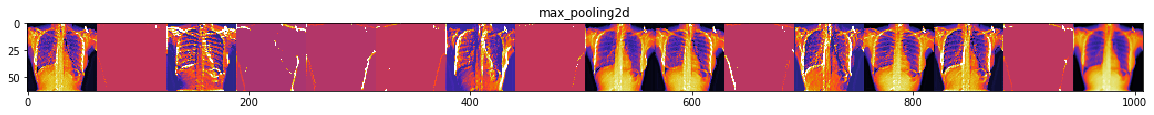

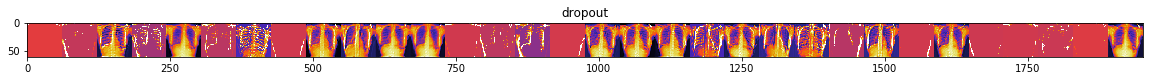

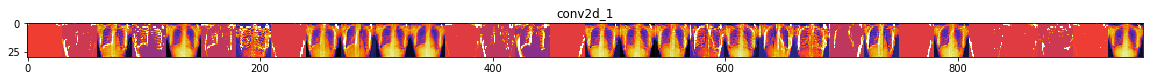

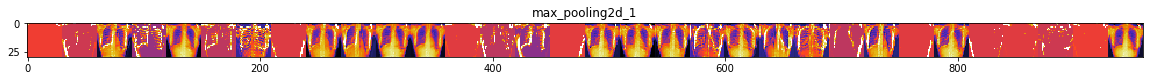

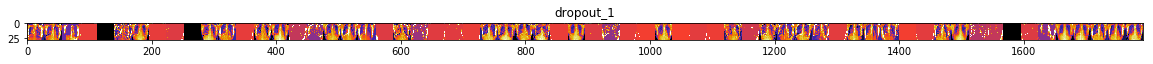

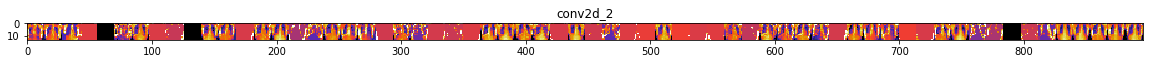

In [49]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='CMRmap')